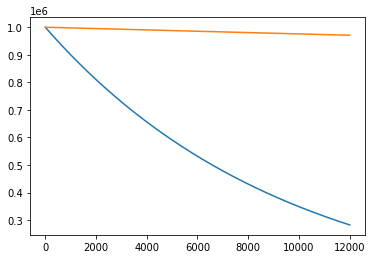

In [1]:
import math
import matplotlib.pyplot as mpl

# Times in seconds
def ActivityAtTime( StartingActivity, TimeElapsed, HalfLife ):
    return StartingActivity * ( 2.0 ** ( -TimeElapsed / HalfLife ) )

def F18ActivityAtTime( StartingActivity, TimeElapsed ):
    return ActivityAtTime( StartingActivity, TimeElapsed, 109.77*60.0 )

def Zr89ActivityAtTime( StartingActivity, TimeElapsed ):
    return ActivityAtTime( StartingActivity, TimeElapsed, 78.41*60.0*60.0 )

def ActivityPlot( StartingActivity, EndTime, ActivityMethod ):
    activityValues = []
    timeValues = []
    time = 0.0
    while time < EndTime:
        activityValues.append( ActivityMethod( StartingActivity, time ) )
        timeValues.append( time )
        time += 1.0
        
    mpl.plot( timeValues, activityValues )
    
ActivityPlot( 1E6, 200.0*60.0, F18ActivityAtTime )
ActivityPlot( 1E6, 200.0*60.0, Zr89ActivityAtTime )
mpl.show()

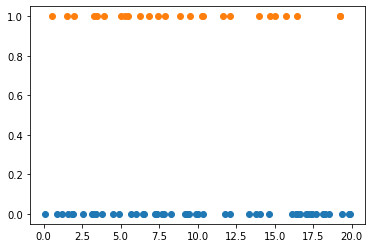

In [2]:
import random

# Simulate poisson-distributed random decay times
# Based on example https://timeseriesreasoning.com/contents/poisson-process/
def DeltaT( DecayRate ):
    randUniform = random.random()
    return -math.log( 1.0 - randUniform ) / DecayRate

def ActivityTimeline( DecayRate, EndTime ):
    decayTimes = []
    time = 0.0
    while time < EndTime:
        time += DeltaT( DecayRate )
        if time < EndTime:
            decayTimes.append( time )
            
    return decayTimes
            
def TimelinesPlot( Timelines ):
    for i, decayTimes in enumerate( Timelines ):
        dummyY = []
        for time in decayTimes:
            dummyY.append( i )
            
        mpl.scatter( decayTimes, dummyY )

TimelinesPlot( [ ActivityTimeline( 2, 20 ), ActivityTimeline( 1, 20 ) ] )
mpl.show()

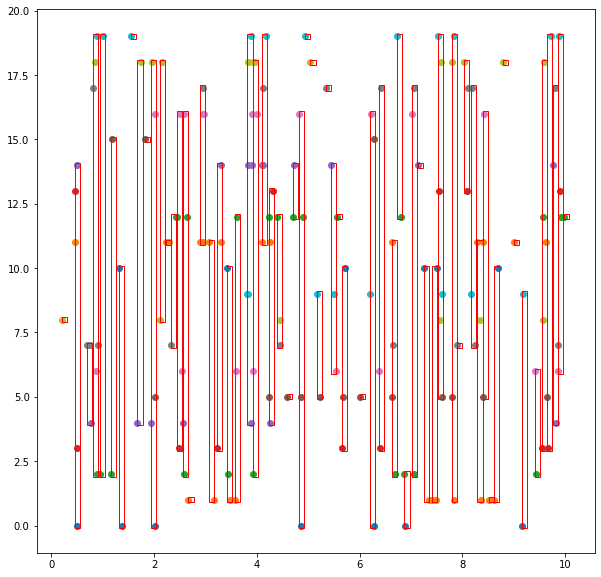

[[8], [0, 3, 11, 13, 14], [4, 7, 7], [2, 6, 7, 17, 18, 19], [2, 19], [2, 15], [0, 10], [19], [4, 18], [15], [0, 4, 5, 16, 18], [8, 18], [11, 11], [7, 12], [3, 6, 12, 16], [2, 4, 12, 16], [1], [11, 11, 16, 16, 17], [1, 11], [3, 11, 14], [1, 2, 10], [1, 6, 12], [4, 9, 9, 14, 14, 16, 18, 19], [2, 6, 16, 18, 18], [11, 14, 14, 17, 19], [4, 5, 11, 12, 13], [7, 8, 12], [5], [12, 14], [0, 5, 12, 16], [19], [18], [5, 9], [17], [6, 9, 14], [12], [3, 5, 10], [5], [0, 9, 15, 16], [3, 6, 17], [2, 5, 7, 11], [12, 19], [0, 2], [2, 16, 17], [14], [1, 10], [1, 1, 10], [5, 8, 9, 13, 18, 19], [1, 5, 18, 19], [7], [13, 17, 18], [7, 9, 17], [1, 8, 11], [5, 11, 16], [1], [1, 10], [18], [11], [0, 9], [2, 6], [3, 8, 11, 12, 18], [3, 5, 19], [4, 7, 14, 17], [6, 12, 13, 19], [12]]


In [3]:
# Avoid pre-generating timelines since it blows up the RAM
def GenerateCoincidences( DecayRates, EndTime, TimeWindow, TimelinesOut = None ):
    coincidences = []
    coincidenceTimes = []
    
    # Set the first event in each timeline
    nextTimes = []
    for channel in range( len( DecayRates ) ):
        nextTimes.append( DeltaT( DecayRates[ channel ] ) )
        if TimelinesOut is not None:
            TimelinesOut.append( [] )
    
    unfinishedTimeline = True
    while unfinishedTimeline:

        # Check if we have anything to process
        unfinishedTimeline = False
        for nextTime in nextTimes:
            if nextTime <= EndTime:
                unfinishedTimeline = True
                break
        
        # Start the window at the earliest event
        time = min( nextTimes )
        #print( nextTimes, " min = ", time )
    
        # Find all events in the window
        coincidence = []
        for channelIndex, nextTime in enumerate( nextTimes ):
            
            while nextTime <= time + TimeWindow and nextTime <= EndTime:
                
                # Store the time point
                coincidence.append( channelIndex )
                if TimelinesOut is not None:
                    TimelinesOut[ channelIndex ].append( nextTime )
                    
                # Update to next time point
                nextTime += DeltaT( DecayRates[ channelIndex ] )
                
            # Store the first event outside the window, for the next coincidence
            nextTimes[ channelIndex ] = nextTime
        
        # The last entry is empty, because all times now past end
        if len( coincidence ) > 0:
            #print( coincidence )    
            coincidences.append( coincidence )
            if TimelinesOut is not None:
                coincidenceTimes.append( time )
    
    return coincidences, coincidenceTimes

from matplotlib.patches import Rectangle

def CoincidenceBoxes( Coincidences, CoincidenceTimes, TimeWindow ):
    
    for i, coincidence in enumerate( Coincidences ):
        time = CoincidenceTimes[ i ]
        y = min( coincidence )
        height = max( coincidence ) - y
        y -= 0.1
        height += 0.2
        mpl.gca().add_patch( Rectangle( (time, y), TimeWindow, height, \
                                        linewidth=1,edgecolor='r',facecolor='none') )

quickTimelines = []
coincidences, coincidenceTimes = GenerateCoincidences( 20 * [1.0], 10.0, 0.1, quickTimelines )
TimelinesPlot( quickTimelines )
CoincidenceBoxes( coincidences, coincidenceTimes, 0.1 )

mpl.gcf().set_size_inches(10, 10)
mpl.show()

print( coincidences )

In [4]:
from SimulationDataset import *

# from the paper energy window 435 keV, 585 keV
crystalData = SimulationDataset( "../crystalRadioactivity.log", 1000000, 435.0, 585.0 )
tracerData = SimulationDataset( "../linearF18.log", 1000000, 435.0, 585.0 )

print( crystalData.SampleOneEvent() )

249016.0 events loaded (1000000 simulated) with average 1.0071119928036754 hits/event
234043.0 events loaded (1000000 simulated) with average 1.0889964664612912 hits/event
[[83702, 533.492, 6.78768e-10, 411.521, -2.21451e-05, -153.248]]


In [20]:
import SiemensQuadraProperties as sqp

#Try and reproduce the plot versus activity
#sampling every 20mins for 700mins
def MaxNECRatTime( tracerData, crystalData, length, doBackground=True, coincidenceWindow=4.7E-9 ):
    necrAtTime = []
    activityAtTime = []
    maxNECR = 0
    maxNECRtime = 0
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        simWindow = 1E-2
        activity = F18ActivityAtTime( 894E6, timeSec )

        # generate coincidences
        coincidences = None
        if doBackground:
            detectorBackground = sqp.Lu176decaysInMass( sqp.DetectorMassLength(length) )
            coincidences, coincidenceTimes = GenerateCoincidences( [activity, detectorBackground], simWindow, coincidenceWindow )
        else:
            coincidences, coincidenceTimes = GenerateCoincidences( [activity], simWindow, coincidenceWindow )


        # classify the coincidences
        trueEvents = 0
        allEvents = 0
        for coincidence in coincidences:
            event = []
            for source in coincidence:
                if source == 0:
                    event += tracerData.SampleOneEvent()
                else:
                    event += crystalData.SampleOneEvent()

            if TwoHitEvent( event ):
                allEvents += 1
                if BackToBackEvent( event, 0.1 ):
                    trueEvents += 1

        necr = trueEvents * trueEvents / ( allEvents * simWindow )
        necrAtTime.append( necr )
        activityAtTime.append( activity )
        if necr > maxNECR:
            maxNECR = necr
            maxNECRtime = time

    mpl.plot( activityAtTime, necrAtTime )
    mpl.gcf().set_size_inches(15, 5)
    mpl.gca().set_xlabel("activity [Bq]")
    mpl.gca().set_ylabel("NECR [cps]")
    #mpl.show()
    
    return maxNECR, maxNECRtime
    
#maxNECR, maxNECRtime = MaxNECRatTime( tracerData, crystalData, 1024 )
#print( maxNECR, maxNECRtime )
#mpl.show()

19962.0 events loaded (1000000 simulated) with average 1.1158701532912534 hits/event
75680.0 events loaded (1000000 simulated) with average 1.0 hits/event
1 1323108.368918865 0
257773.0 events loaded (1000000 simulated) with average 1.1621930923719708 hits/event
105985.0 events loaded (1000000 simulated) with average 1.0075765438505448 hits/event
501 2191737.724154585 120
363801.0 events loaded (1000000 simulated) with average 1.1635399572843395 hits/event
107165.0 events loaded (1000000 simulated) with average 1.0078010544487472 hits/event
1001 1856018.5499922037 180
395906.0 events loaded (1000000 simulated) with average 1.1598864376897546 hits/event
106797.0 events loaded (1000000 simulated) with average 1.0076313005046957 hits/event
1501 1664811.4469671296 180
406568.0 events loaded (1000000 simulated) with average 1.1593804726392634 hits/event
107223.0 events loaded (1000000 simulated) with average 1.0077315501338333 hits/event
2001 1617277.8745794876 180


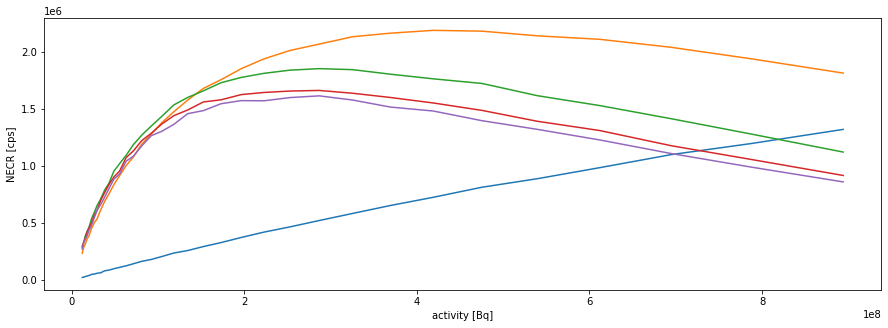

In [10]:
# Loop over detector lengths, find max NECR

for length in range( 1, 2002, 500 ):
    tracerData = CreateDataset( length, "LinearF18", 1000000, 435.0, 585.0 )
    crystalData = CreateDataset( length, "Siemens", 1000000, 435.0, 585.0 )
    maxNECR, maxNECRtime = MaxNECRatTime( tracerData, crystalData, length )
    print( length, maxNECR, maxNECRtime )
    
mpl.show()

19962.0 events loaded (1000000 simulated) with average 1.1158701532912534 hits/event
1 1314013.8632458136 0
257773.0 events loaded (1000000 simulated) with average 1.1621930923719708 hits/event
501 2212640.5452890876 120
363801.0 events loaded (1000000 simulated) with average 1.1635399572843395 hits/event
1001 1881678.4337668682 200
395906.0 events loaded (1000000 simulated) with average 1.1598864376897546 hits/event
1501 1705106.5824509857 200
406568.0 events loaded (1000000 simulated) with average 1.1593804726392634 hits/event
2001 1660006.9281432068 200


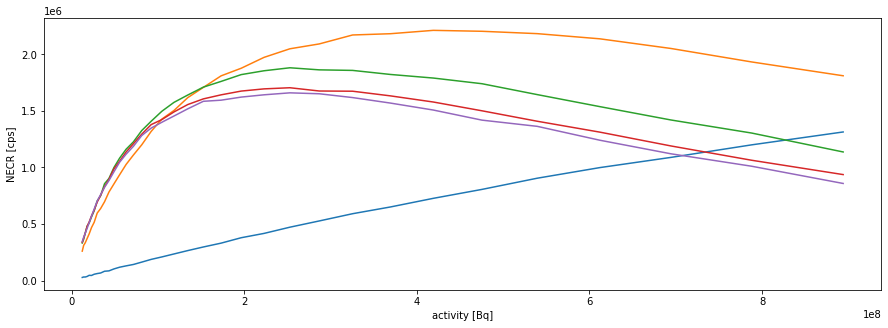

In [12]:
# Loop over detector lengths, find max NECR
# try with no background
for length in range( 1, 2002, 500 ):
    tracerData = CreateDataset( length, "LinearF18", 1000000, 435.0, 585.0 )
    maxNECR, maxNECRtime = MaxNECRatTime( tracerData, None, length, doBackground=False )
    print( length, maxNECR, maxNECRtime )
    
mpl.show()

78295.0 events loaded (1000000 simulated) with average 1.1328948208697873 hits/event
106634.0 events loaded (1000000 simulated) with average 1.007192827803515 hits/event
100 2390322.5084557636 0
131275.0 events loaded (1000000 simulated) with average 1.1480327556655876 hits/event
105833.0 events loaded (1000000 simulated) with average 1.0069921480067654 hits/event
200 2518024.1335104476 0
179537.0 events loaded (1000000 simulated) with average 1.1584185989517481 hits/event
106692.0 events loaded (1000000 simulated) with average 1.0077700296179657 hits/event
300 2483213.8672969323 40
221652.0 events loaded (1000000 simulated) with average 1.1612437514662624 hits/event
106214.0 events loaded (1000000 simulated) with average 1.007343664676973 hits/event
400 2335234.7490599435 80
257773.0 events loaded (1000000 simulated) with average 1.1621930923719708 hits/event
106139.0 events loaded (1000000 simulated) with average 1.0072546377862992 hits/event
500 2190042.3694602894 100
286748.0 event

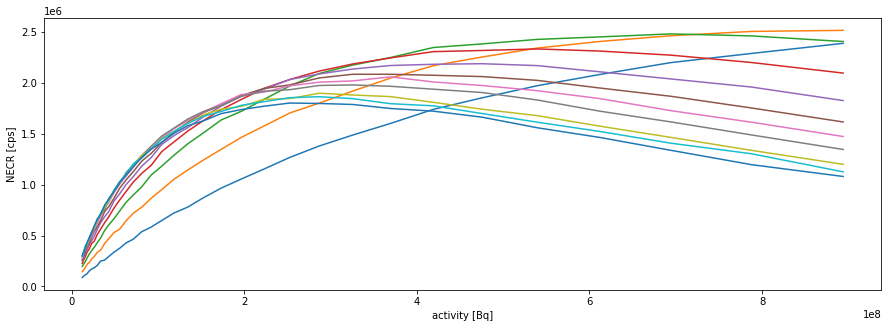

In [19]:
# Loop over detector lengths, find max NECR

lengths = []
maxNECRs = []
for length in range(100, 1200, 100):
    tracerData = CreateDataset( length, "LinearF18", 1000000, 435.0, 585.0 )
    crystalData = CreateDataset( length, "Siemens", 1000000, 435.0, 585.0 )
    maxNECR, maxNECRtime = MaxNECRatTime( tracerData, crystalData, length )
    print( length, maxNECR, maxNECRtime )
    #lengths.append( sqp.DetectorDiscreteLength( length ) )
    lengths.append( math.ceil(length/32.0) * 32.0 ) #temp
    maxNECRs.append(maxNECR)
    
mpl.show()

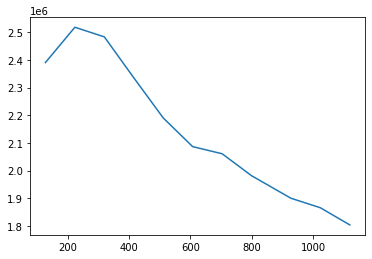

In [21]:
mpl.plot( lengths, maxNECRs )
mpl.show()

#NOTE this peaks early but I may have got the background calculation wrong (radiation outside detector)

78295.0 events loaded (1000000 simulated) with average 1.1328948208697873 hits/event
106634.0 events loaded (1000000 simulated) with average 1.007192827803515 hits/event
100 4905710.579892066 0
131275.0 events loaded (1000000 simulated) with average 1.1480327556655876 hits/event
105833.0 events loaded (1000000 simulated) with average 1.0069921480067654 hits/event
200 6813794.086208789 0
179537.0 events loaded (1000000 simulated) with average 1.1584185989517481 hits/event
106692.0 events loaded (1000000 simulated) with average 1.0077700296179657 hits/event
300 8115509.783595908 0
221652.0 events loaded (1000000 simulated) with average 1.1612437514662624 hits/event
106214.0 events loaded (1000000 simulated) with average 1.007343664676973 hits/event
400 8605097.774418663 0
257773.0 events loaded (1000000 simulated) with average 1.1621930923719708 hits/event
106139.0 events loaded (1000000 simulated) with average 1.0072546377862992 hits/event
500 8714457.161727581 0
286748.0 events loaded 

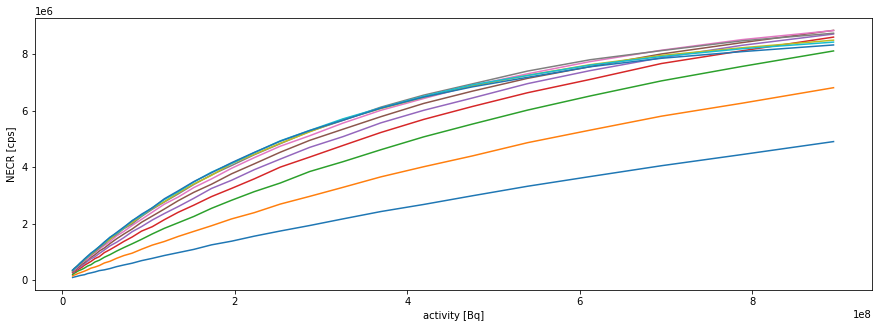

In [22]:
# Loop over detector lengths, find max NECR
# shorter time to reduce signal overlap?
lengths = []
maxNECRs = []
for length in range(100, 1200, 100):
    tracerData = CreateDataset( length, "LinearF18", 1000000, 435.0, 585.0 )
    crystalData = CreateDataset( length, "Siemens", 1000000, 435.0, 585.0 )
    maxNECR, maxNECRtime = MaxNECRatTime( tracerData, crystalData, length, coincidenceWindow=1E-9 )
    print( length, maxNECR, maxNECRtime )
    #lengths.append( sqp.DetectorDiscreteLength( length ) )
    lengths.append( math.ceil(length/32.0) * 32.0 ) #temp
    maxNECRs.append(maxNECR)
    
mpl.show()

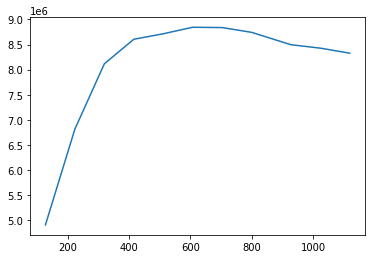

In [23]:
mpl.plot( lengths, maxNECRs )
mpl.show()

#NOTE THE PEAK AT 700 is with 1ns coincidence
#also may have got the background wrong